# Import necessary libraries/modules

In [12]:
# Import necessary libraries/functions/modules
import nltk
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')  # Download NLTK resources (if not done previously)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Functions

In [2]:
# Function used to evaluate the model:
def model_evaluator(model, dataset):
    # Prepare the output data:
    output_data = []

    # Iterate through each row in the dataset
    for index, row in dataset.iterrows():
        # Extract the question and answer words from the current row
        question_word = row['question']
        answer_word = row['answer']

        # Generate a list of guess words from the current row
        guess_words = [row[str(i)] for i in range(4)]

        # Check if the question word is in the model
        if question_word in model:
            # Initialize a list to store similarities between question and guess words
            similarities = []

            # Loop through each guess word
            for guess_word in guess_words:
                # Check if the guess word is in the model
                if guess_word in model:
                    # Calculate the similarity between question and guess word using the similarity method from Gensim
                    similarity = model.similarity(question_word, guess_word)
                    # Store the guess word and its similarity score
                    similarities.append((guess_word, similarity))

            # Determine the best guess based on the highest similarity score
            if similarities:
                best_guess, _ = max(similarities, key=lambda x: x[1])
                # Label as "correct" if the best guess matches the answer word
                label = 'correct' if best_guess == answer_word else 'wrong'
            else:
                # If no valid guesses, set best guess to None and label as "guess"
                best_guess = None
                label = 'guess'
        else:
            # If question word is not in the model, no guess can be made
            best_guess = None
            label = 'guess'

        # Append the results to the output data
        output_data.append([question_word, answer_word, best_guess, label])
    return output_data

In [3]:
# Function used to transform the data into a DataFrame and CSV file:
def output_df(output_data, model_name):
    # Convert the output data to a DataFrame and save the output to a CSV file:
    output_df = pd.DataFrame(output_data, columns=['question-word', 'answer-word', 'guess-word', 'label'])
    output_df.to_csv(model_name + "-details.csv", index=False)
    return output_df

In [4]:
# Function used to compute the metrics:
def compute_accuracy(output_df):
    # 1. Count the number of correct (C) and non-guess labels (V):
    C = (output_df['label'] == 'correct').sum()
    V = (output_df['label'] != 'guess').sum()

    # 2. Calculate the accuracy:
    if V:
        accuracy = C / V
    else:
        accuracy = 0
    return C, V, accuracy

In [5]:
# Function used to save all the details of several models in a dictionary:
def save_data(analysis_dic, model_name, model, output_data):
    C, V, accuracy = compute_accuracy(output_df(output_data, model_name))
    new_entry = {
        'model_name': model_name,
        'vocabulary_size': len(model.key_to_index),
        'correct_labels': C,
        'answered_questions': V,
        'accuracy': accuracy
    }
    analysis_dic[model_name] = new_entry

In [6]:
# Preprocess function to tokenize and split sentences
def preprocess_books(books):
    sentences = []
    for book in books:
        with open(book, 'r', encoding='utf-8') as file:
            text = file.read()
            # Tokenize into sentences
            # .extend removes duplicates from the vocabulary list
            sentences.extend(sent_tokenize(text))
    return [word_tokenize(sentence.lower()) for sentence in sentences]

# Tasks

## Task 1

In [15]:
# Load the pretrained embedding model:
model_name = "word2vec-google-news-300"
model = gensim.downloader.load(model_name)

# Load the Synonym Test dataset:
dataset = pd.read_csv("A2-Dataset/synonym.csv")

# Save the data:
analysis_dic = {}
save_data(analysis_dic, model_name, model, model_evaluator(model, dataset))

# Convert dictionary to DataFrame:
analysis_df = pd.DataFrame.from_dict(analysis_dic, orient="index")

# Save the DataFrame to a CSV file:
analysis_df.to_csv('analysis.csv', index=False, header=False)

## Task 2

In [10]:
# Load the pretrained embedding model:
model_name1 = "glove-wiki-gigaword-300"
model_name2 = "fasttext-wiki-news-subwords-300"
model_name3 = "glove-twitter-100"
model_name4 = "glove-twitter-200"

model1 = gensim.downloader.load(model_name1)
model2 = gensim.downloader.load(model_name2)
model3 = gensim.downloader.load(model_name3)
model4 = gensim.downloader.load(model_name4)

# Save the data:
save_data(analysis_dic, model_name1, model1, model_evaluator(model1, dataset))
save_data(analysis_dic, model_name2, model2, model_evaluator(model2, dataset))
save_data(analysis_dic, model_name3, model3, model_evaluator(model3, dataset))
save_data(analysis_dic, model_name4, model4, model_evaluator(model4, dataset))

# Convert dictionary to DataFrame:
analysis_df = pd.DataFrame.from_dict(analysis_dic, orient="index")

# Save the DataFrame to a CSV file:
analysis_df.to_csv('analysis.csv', index=False, header=False)

[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded
[==================================================] 100.0% 387.1/387.1MB downloaded
[==================================================] 100.0% 758.5/758.5MB downloaded


## Task 3

In [17]:
# Declare variables that will be used in the task, such as the books, the window
# sizes or the embedding sizes:
books = ['Books/agnes_grey.txt', 'Books/frankestein.txt', 'Books/jane_eyre.txt',
         'Books/little_women.txt', 'Books/mrs_dalloway.txt', 'Books/pride_and_prejudice.txt',
         'Books/regiment_of_women.txt', 'Books/wuthering_heights.txt']
window_sizes = [100, 200]
embedding_sizes = [100, 300]

for window_size in window_sizes:
    for embedding_size in embedding_sizes:
        model_name = f'Model_W{window_size}_E{embedding_size}'

        # Preprocess books:
        sentences = preprocess_books(books)

        # Train Word2Vec model:
        model = Word2Vec(sentences, vector_size = embedding_size, window = window_size, min_count = 1, workers = 4)

        # Save details to CSV:
        save_data(analysis_dic, model_name, model.wv, model_evaluator(model.wv, dataset))

        # Convert dictionary to DataFrame:
        analysis_df = pd.DataFrame.from_dict(analysis_dic, orient="index")

        # Save the DataFrame to a CSV file:
        analysis_df.to_csv('analysis.csv', index=False, header=False)

### Comparison of the performance of models

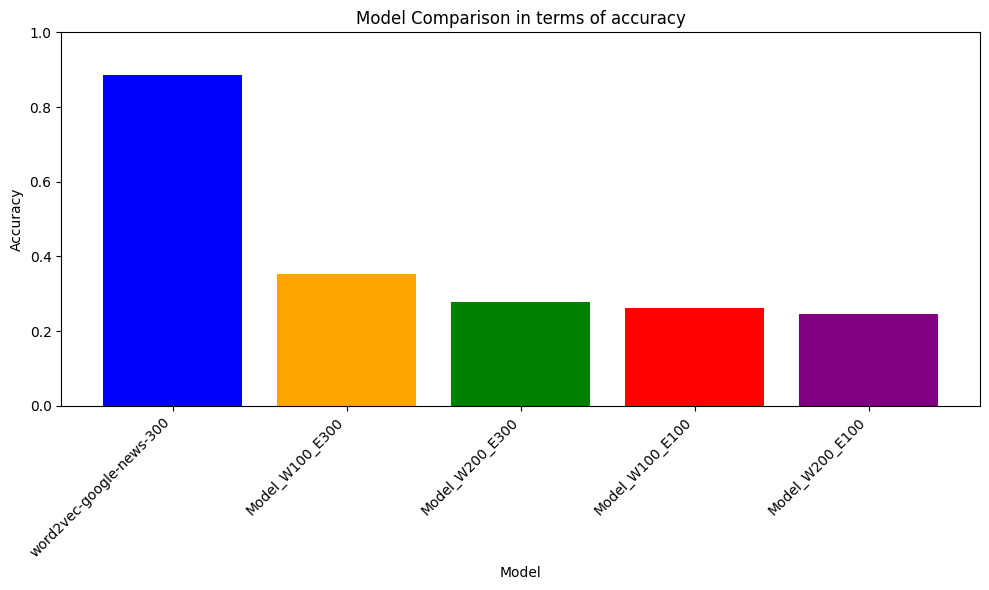

In [18]:
# Load analysis results from the CSV file:
analysis_df = pd.read_csv('analysis.csv', header=None, names=['model_name', 'vocabulary_size', 'correct_labels', 'answered_questions', 'accuracy'])

# Sort the DataFrame by accuracy in descending order:
analysis_df = analysis_df.sort_values(by='accuracy', ascending=False)

# Plot the bar graph:
plt.figure(figsize=(10, 6))
plt.bar(analysis_df['model_name'], analysis_df['accuracy'], color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison in terms of accuracy')
plt.ylim(0, 1)  # Set y-axis limit to better visualize differences
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save the plot as an image (optional):
plt.savefig('model_comparison_accuracy.png')

# Display the plot:
plt.show()